## Spatial molecular niche discovery (multi-modality data)

Here we will use spatial ATAC-RNA-seq mouse brain dataset as an example to illustrate how Garfield performs spatial multi-omics integration analysis. Data access: https://www.nature.com/articles/s41586-023-05795-1.

In [1]:
import os
import pandas as pd
import numpy as np

os.chdir('/data2/zhouwg_data/project/Garfield')
os.getcwd()

'/data2/zhouwg_data/project/Garfield'

In [2]:
# load packages
import os
import warnings
import Garfield as gf
import scanpy as sc
from mudata import MuData
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

gf.__version__

'0.3.1'

In [3]:
# Load data
# Define paths
st_data_folder_path = "/home/zhouweige/zhouwg_data/project/Garfield_tutorials/data" # spatially resolved transcriptomics data
dataset = "spatial_atac_rna_seq_mouse_brain"
cell_type_key = "celltype"
sample_key = "batch"

adata_rna = sc.read_h5ad(
        f"{st_data_folder_path}/{dataset}_rna.h5ad")
# adata_rna.layers['counts'] = adata_rna.X.copy()
adata_atac = sc.read_h5ad(
        f"{st_data_folder_path}/{dataset}_atac.h5ad")
# adata_atac.layers['counts'] = adata_atac.X.copy()

# Load and add cell type annotations
cell_type_df = pd.read_csv(f"{st_data_folder_path}/{dataset}_cell_type_annotations.csv", index_col=0)
cell_type_df.rename({"predicted.celltype": cell_type_key}, axis=1, inplace=True)
cell_type_df.drop("ATAC_clusters", axis=1, inplace=True)
adata_rna.obs = adata_rna.obs.merge(cell_type_df, left_index=True, right_index=True, how="left")

In [4]:
# check the batch information of this dataset
adata_rna.obs['batch'].value_counts()

batch
p22    9215
Name: count, dtype: int64

In [5]:
# check the batch information of this dataset
adata_rna.obs['celltype'].value_counts()

celltype
D2MSN      1291
ITL23GL     931
D1MSN       845
MSGA        697
ASC         559
CTGL        503
VPIA        455
ITL6GL      446
MGL         412
OGC         367
LSXGA       304
ITL5GL      281
OPC         221
L6bGL       209
ITL4GL      176
RGL         147
PVGA        145
PTGL        142
IOL         128
STRGA       113
CLAGL       113
VEC         102
VLMC         98
OLFGL        96
SSTGA        96
LAMGA        82
OBGA1        75
NPGL         63
MXD          42
VIPGA        37
PIRGL        26
CA3GL         7
PER           6
Name: count, dtype: int64

In [6]:
# Ensure adata.X is counts.
adata_rna.X.max()

850.0

In [7]:
# filter adata_atac through adata_atac.var_names
filtered_var_names = adata_atac.var_names[adata_atac.var_names.str.startswith('chr')]
adata_atac = adata_atac[:, filtered_var_names]

# split each element for gene score calculation
split_data = adata_atac.var_names.str.extract(r'(chr\d+):(\d+)-(\d+)')
split_data.columns = ['chr', 'start', 'end']
split_data.index = adata_atac.var_names
# Drop rows containing NaN values
split_data = split_data.dropna()
adata_atac = adata_atac[:, adata_atac.var_names.isin(split_data.index)]
adata_atac.var[['chr', 'start', 'end']] = split_data

mdata = MuData({"rna": adata_rna, "atac": adata_atac})
mdata

MuData object with n_obs × n_vars = 9215 × 142058
  2 modalities
    rna:	9215 x 22914
      obs:	'RNA_clusters', 'ATAC_clusters', 'batch', 'celltype'
      obsm:	'spatial'
      layers:	'counts'
    atac:	9215 x 119144
      obs:	'RNA_clusters', 'ATAC_clusters', 'batch'
      var:	'chr', 'start', 'end'
      obsm:	'spatial'
      layers:	'counts'

## Perform spatial multi-omics integration using Garfield

For integration of spatial multi-omics data, we should adjust the following paremeters, and all parameter introductions can be found in [Garfield_Model_Parameters](https://github.com/zhou-1314/Garfield/blob/main/Garfield_Model_Parameters.md).

In [8]:
# set workdir
workdir = '/home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_spatial_multiome_mouse_brain'
gf.settings.set_workdir(workdir)

### modify parameter
user_config = dict(
    ## Input options
    adata_list=mdata, 
    profile='spatial',   # if it is 'ATAC', 'ADT' or 'multi-modal', please adjust it.
    data_type='multi-modal',
    sub_data_type=['rna', 'atac'],
    sample_col=None,  # Specify columns for batch, only one batch, so set `None`. otherwise, please set as "rna:batch"
    graph_const_method='mu_std', # mu_std, Radius, KNN, Squidpy for spatial data; scanpy for single-cell data
    weight=0.5,
    ## Preprocessing options
    genome='mm10', # human: hg19 or hg38; mouse: mm0 or mm10
    use_gene_weight=True,
    use_top_pcs=False,
    used_hvg=True,
    min_cells=3,
    min_features=0,
    keep_mt=False,
    target_sum=1e4,
    rna_n_top_features=3000,
    atac_n_top_features=10000, # if data belongs to 'ATAC', please specify it.
    n_components=50,
    n_neighbors=5,
    metric='euclidean', 
    svd_solver='arpack',
    # datasets
    used_pca_feat=True,
    adj_key='connectivities',
    # data split parameters
    edge_val_ratio=0.1,
    edge_test_ratio=0.,
    node_val_ratio=0.1,
    node_test_ratio=0.,
    ## Model options
    augment_type='svd',
    svd_q=5,
    use_FCencoder=True, 
    conv_type='GATv2Conv', # GAT or GATv2Conv or GCN
    gnn_layer=2,
    hidden_dims=[128, 128],
    bottle_neck_neurons=20,
    cluster_num=20,
    drop_feature_rate=0.2, 
    drop_edge_rate=0.2,
    num_heads=3,
    dropout=0.2,
    concat=True,
    used_edge_weight=True,
    used_DSBN=False,
    used_mmd=False,
    # data loader parameters
    num_neighbors=5,
    loaders_n_hops=2,
    edge_batch_size=4096,
    node_batch_size=128, # None
    # loss parameters
    include_edge_recon_loss=True,
    include_gene_expr_recon_loss=True,
    lambda_latent_contrastive_instanceloss=1.0,
    lambda_latent_contrastive_clusterloss=0.5,
    lambda_gene_expr_recon=500., # To make the model more focused on learning expression features, increase this parameter.
    lambda_edge_recon=300., # To make the model more focused on learning Adjacency graph features, increase this parameter.
    lambda_omics_recon_mmd_loss=1., # If the integration is not strong enough, increase it.
    # train parameters
    n_epochs_no_edge_recon=0,
    learning_rate=0.001,
    weight_decay=1e-05,
    gradient_clipping=5,
    # other parameters
    latent_key='garfield_latent',
    reload_best_model=True,
    use_early_stopping=True,
    early_stopping_kwargs=None,
    monitor=True,
    seed=2024,
    verbose=True
)
dict_config = gf.settings.set_gf_params(user_config)

Saving results in: /home/zhouweige/zhouwg_data/project/Garfield_tutorials/result/garfield_spatial_multiome_mouse_brain


In [9]:
from Garfield.model import Garfield

# Initialize model
model = Garfield(dict_config)

--- DATA LOADING AND PREPROCESSING ---
Gene activity matrix has been calculated, and loading cached adata_CG_atac object...
There are 15628 common genes in RNA and ATAC datasets
To start performing cell matching for adjacency matrix of the graph, please wait...
Init_matching done!
Refined_matching done!
Filter_bad_matches on pivots matching...
Begin filtering...
6450/9215 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
Done!
Filter_bad_matches on propagated matching...
Begin filtering...
5530/5530 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
------Calculating spatial graph...
COSINE SIM GRAPH DECODER -> dropout_rate: 0.2


In [10]:
# Train model
model.train()


--- INITIALIZING TRAINER ---
Number of training nodes: 8293
Number of validation nodes: 922
Number of training edges: 27399
Number of validation edges: 3044
Edge batch size: 4096
Node batch size: 128

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.6670; val_auprc_score: 0.6532; val_best_acc_score: 0.6234; val_best_f1_score: 0.6839; train_kl_reg_loss: 4.6021; train_edge_recon_loss: 209.9580; train_gene_expr_recon_loss: 1734.9316; train_lambda_latent_contrastive_instanceloss: 7.2050; train_lambda_latent_contrastive_clusterloss: 3.6995; train_global_loss: 1960.3962; train_optim_loss: 1960.3962; val_kl_reg_loss: 1.7637; val_edge_recon_loss: 214.0631; val_gene_expr_recon_loss: 1711.8774; val_lambda_latent_contrastive_instanceloss: 7.0382; val_lambda_latent_contrastive_clusterloss: 3.7682; val_global_loss: 1938.5107; val_optim_loss: 1938.5107
Epoch 2/100 |--------------------| 2.0% val_auroc_score: 0.7254; val_auprc_score: 0.7120; val_best_acc_score: 0.663

In [11]:
# Compute latent neighbor graph
latent_key = 'garfield_latent'
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)
# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

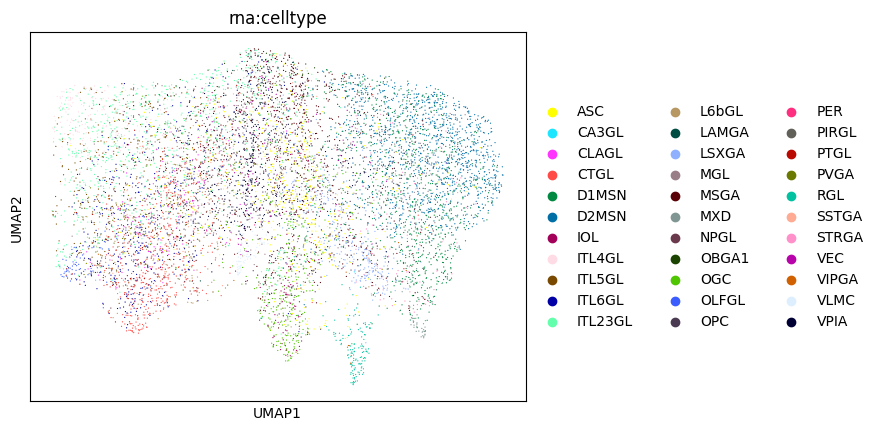

In [12]:
sc.pl.umap(model.adata, color=['rna:celltype'], show=True, size=3) 

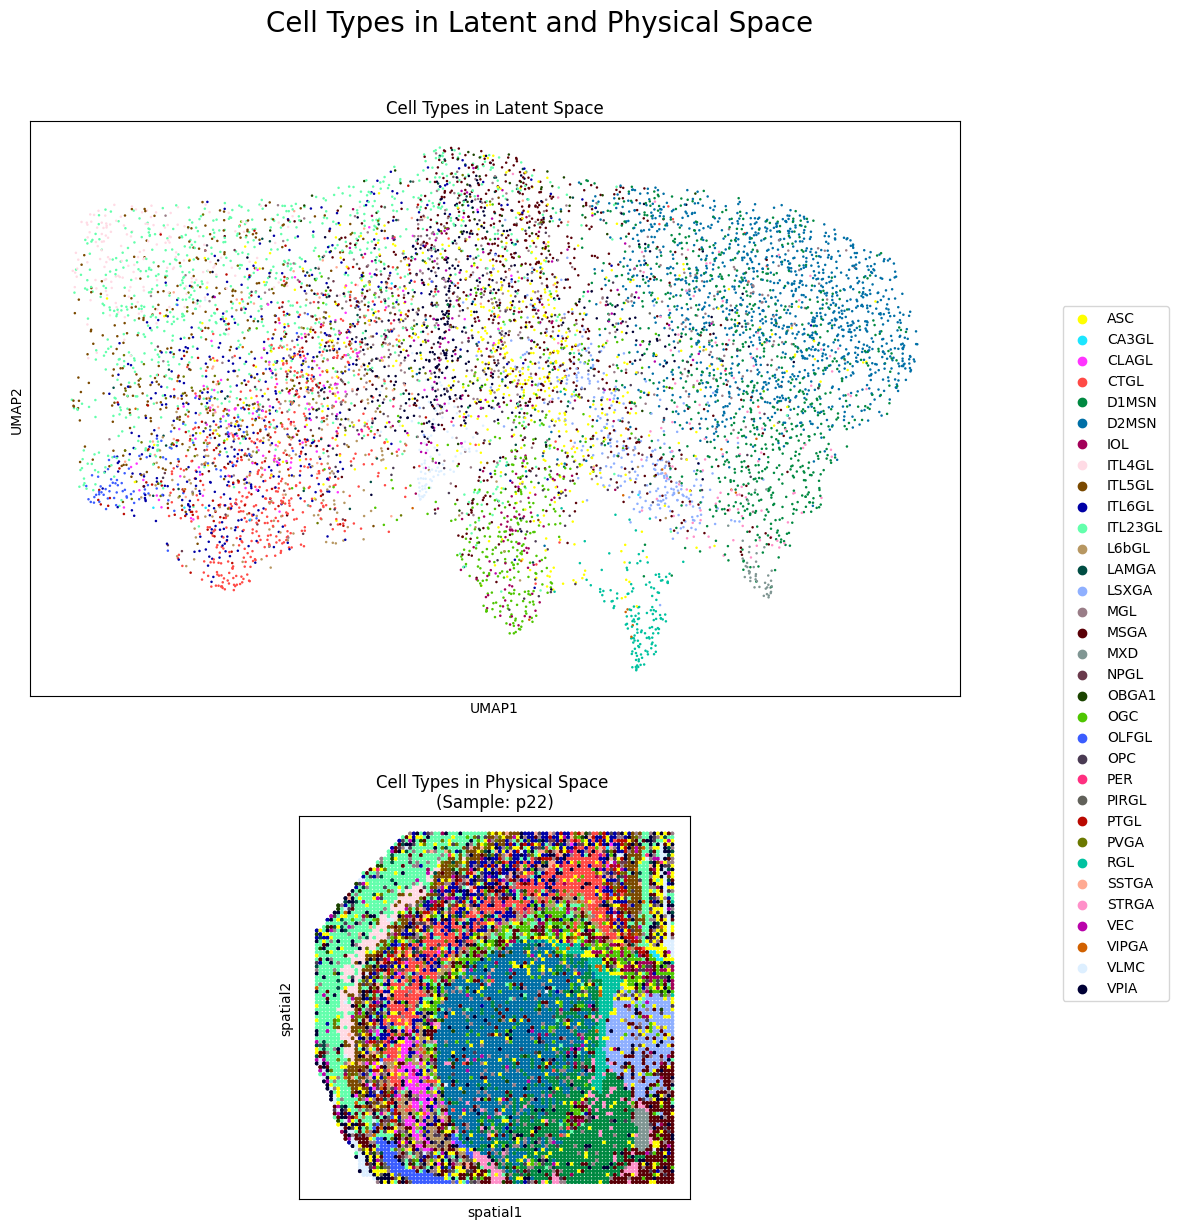

In [13]:
# Create plot of cell type annotations in physical and latent space
import matplotlib.pyplot as plt
from matplotlib import gridspec
import squidpy as sq

groups = None
sample_key = "rna:batch"
cell_type_key = "rna:celltype"
samples = model.adata.obs[sample_key].unique().tolist()

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t="Cell Types in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,
           # palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)

for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sq.pl.spatial_scatter(adata=model.adata[model.adata.obs[sample_key] == sample],
                          color=[cell_type_key], 
                          shape=None, 
                          # palette=cell_type_colors,,
                          title=f"Cell Types in Physical Space \n"
                                f"(Sample: {sample})",
                          ax=axs[idx+1],
                          legend_loc=None,
                          figsize=(12, 12))

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
plt.show()

## Identify Niches

We compute Leiden clustering of the Garfield latent space to identify spatially consistent cell niches.

In [14]:
# Compute latent Leiden clustering
latent_leiden_resolution = 1.0
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
latent_key = "garfield_latent"

sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)
len(model.adata.obs[latent_cluster_key].unique())

19

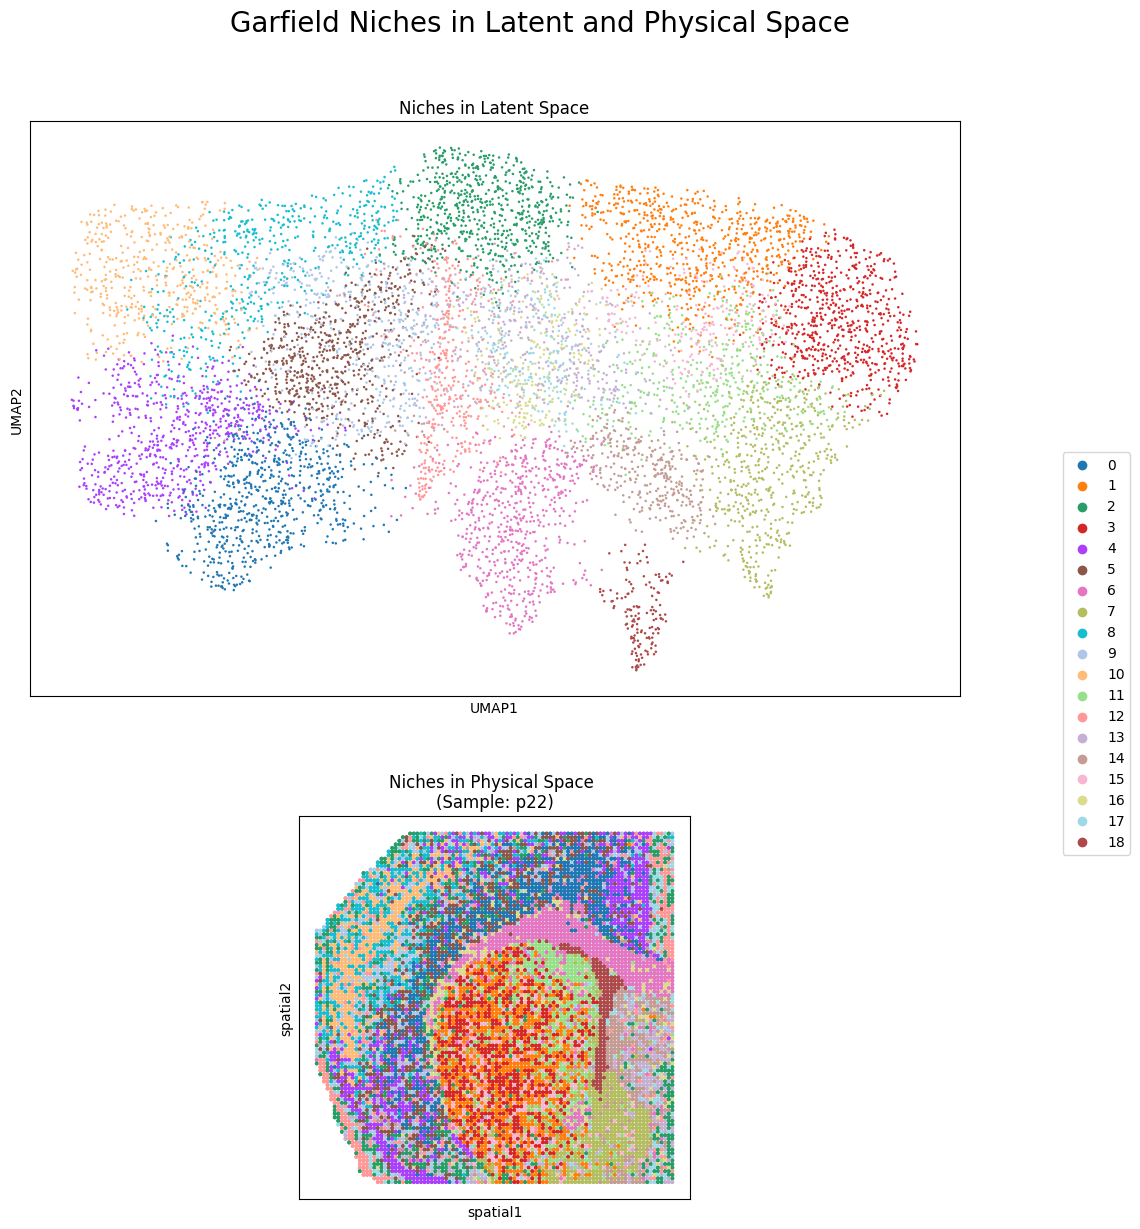

In [15]:
# Create plot of cell type annotations in physical and latent space
import matplotlib.pyplot as plt
from matplotlib import gridspec
import squidpy as sq

groups = None
sample_key = "rna:batch"
samples = model.adata.obs[sample_key].unique().tolist()

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Garfield Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           # palette=cell_type_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)

for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sq.pl.spatial_scatter(adata=model.adata[model.adata.obs[sample_key] == sample],
                          color=[latent_cluster_key], 
                          shape=None, 
                          # palette=cell_type_colors,,
                          title=f"Niches in Physical Space \n"
                                f"(Sample: {sample})",
                          ax=axs[idx+1],
                          legend_loc=None,
                          figsize=(12, 12))

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
plt.show()

In [ ]:
# Save trained model
model_folder_path = f"{workdir}/model"
os.makedirs(model_folder_path, exist_ok=True)

model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata_ref.h5ad")